# 密度聚类：实现 DBSCAN 聚类算法
（1） 总体要求
+ 使用 DBSCAN 算法手动实现聚类，不要直接调用库函数；在合成数据集上
+ 评估聚类结果；比较不同参数对模型性能个影响。
（2） 实验说明
1. 自选至少一数合成数据集（dataset/02- Synthetic）；
2. 手动实现 DBSCAN 聚类算法；
3. 分析合成数据集个数据分布特性，可视化比较 ϵ-邻域大小及聚类数对模型性能个影响。
4. Notebook 需要包含关键次码注释初结果分析内容。

## 1. 导入库

In [1]:
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, normalized_mutual_info_score, adjusted_rand_score

`sklearn.metrics` 包含多个聚类性能评价指标，后续将用于评估 DBSCAN 聚类结果。

## 2. 欧几里得距离计算

In [2]:
def euclidean_distance(point1, point2):
    return sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

计算两个二维点之间的欧几里得距离

## 3. DBSCAN 类的手动实现

In [3]:
class DBSCAN:
    def __init__(self, epsilon=0.5, min_points=5):
        self.epsilon = epsilon  # 邻域半径
        self.min_points = min_points  # 最小点数
        self.labels_ = None  # 聚类结果标签
        
    def fit(self, X):
        n_samples = len(X)
        self.labels_ = np.full(n_samples, -1)  # -1 表示噪声点
        cluster_id = 0
        visited = np.zeros(n_samples, dtype=bool)
        
        def region_query(i):
            neighbors = []
            for j in range(n_samples):
                if euclidean_distance(X[i], X[j]) < self.epsilon:
                    neighbors.append(j)
            return neighbors
        
        def expand_cluster(i, neighbors, cluster_id):
            self.labels_[i] = cluster_id
            queue = neighbors[:]
            while queue:
                j = queue.pop(0)
                if not visited[j]:
                    visited[j] = True
                    new_neighbors = region_query(j)
                    if len(new_neighbors) >= self.min_points:
                        queue.extend(new_neighbors)
                if self.labels_[j] == -1:
                    self.labels_[j] = cluster_id
        
        for i in range(n_samples):
            if not visited[i]:
                visited[i] = True
                neighbors = region_query(i)
                if len(neighbors) < self.min_points:
                    self.labels_[i] = -1  # 标记为噪声点
                else:
                    expand_cluster(i, neighbors, cluster_id)
                    cluster_id += 1

+ `epsilon`控制邻域的半径（搜索区域大小）。
+ `min_points` 表示一个簇的最小点数。
+ `region_query(i)`：为每个点找到其邻域中的所有点。
+ `expand_cluster(i, neighbors, cluster_id)`：基于邻域信息扩展簇，递归处理所有与当前点邻近的点。
+ `fit(X)`：根据给定数据集 X 执行聚类并返回聚类标签。

## 4. 加载数据和数据预处理

In [5]:
file_path = '/home/aistudio/dataset/02-Synthetic/complex9.csv'
data = pd.read_csv(file_path)

X = data[['x', 'y']].values
true_labels = data['class'].values  # class是真实标签

从 CSV 文件中加载数据，并提取出二维坐标数据（x, y）作为特征，class 列作为真实标签。

## 5. 测试 DBSCAN 并可视化不同的 epsilon 值

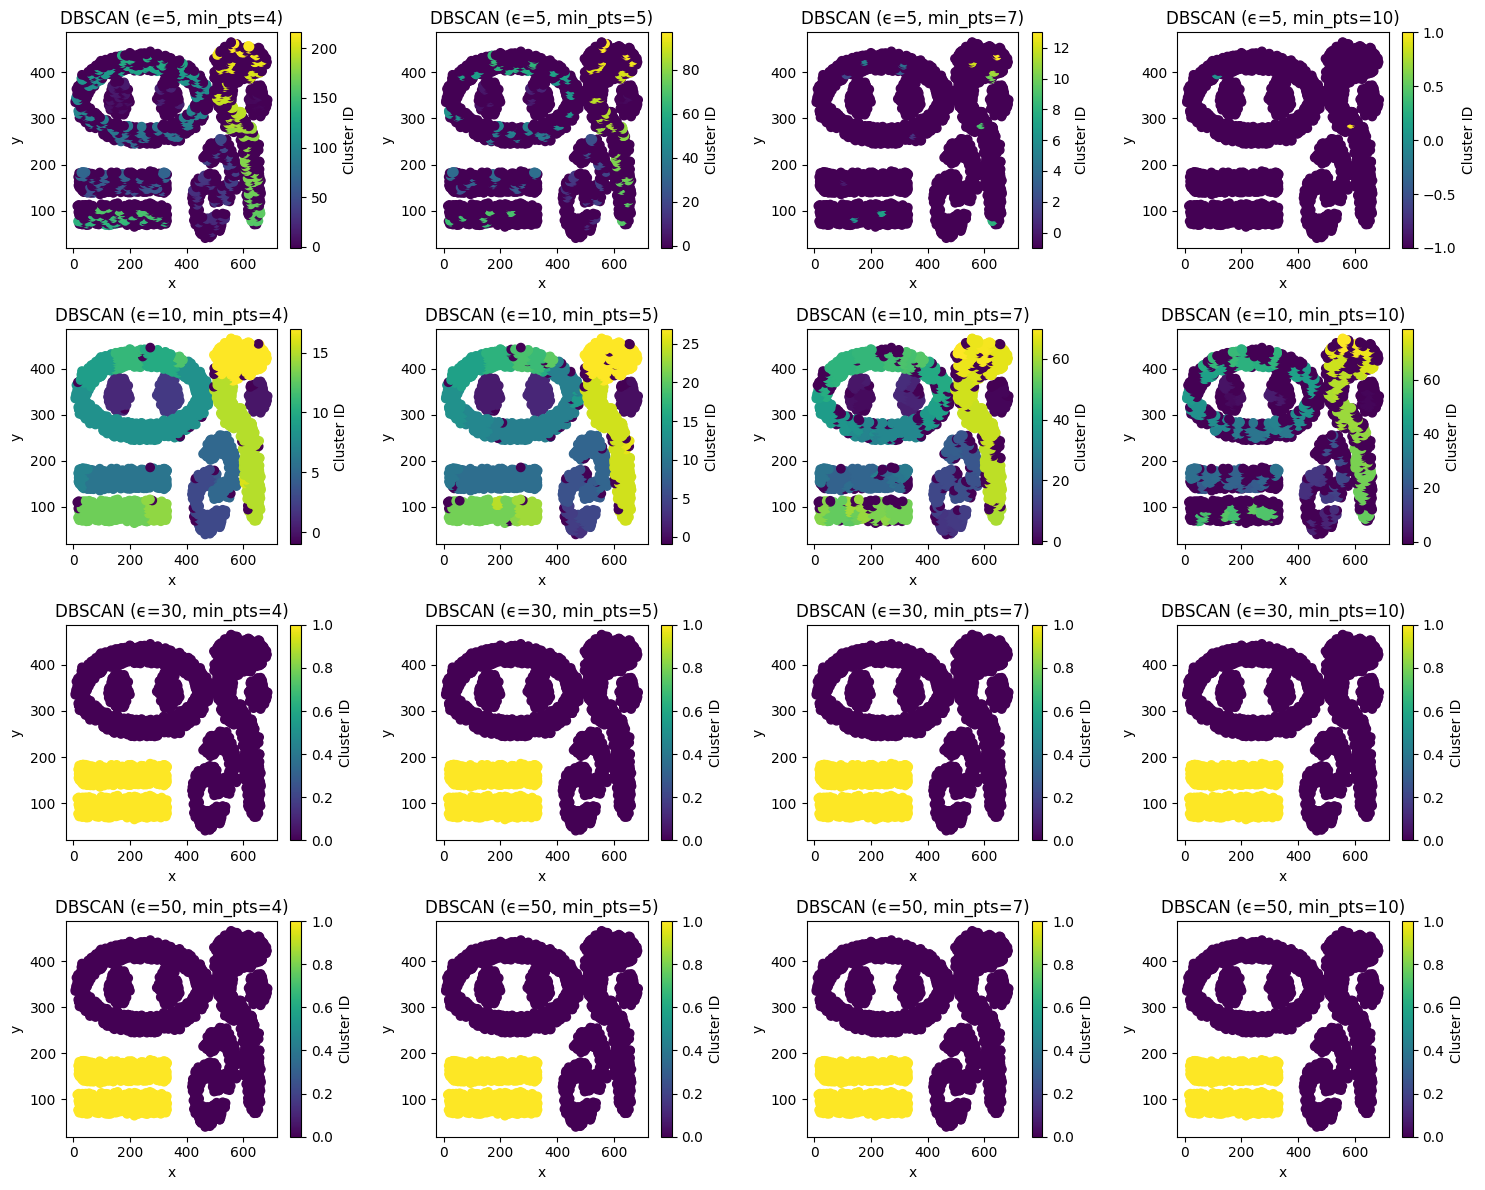

In [10]:
epsilons = [5, 10, 30, 50]  # 尝试不同的 epsilon 值
min_pts_values = [4, 5, 7, 10]  # 尝试不同的 min_pts 值
performance_metrics = []

fig, axes = plt.subplots(len(epsilons), len(min_pts_values), figsize=(15, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

for i, epsilon in enumerate(epsilons):
    for j, min_pts in enumerate(min_pts_values):
        dbscan = DBSCAN(epsilon=epsilon, min_points=min_pts)
        dbscan.fit(X)
        data['cluster'] = dbscan.labels_

        unique_labels = np.unique(dbscan.labels_)
        num_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)  # 排除噪声
        num_noise = np.sum(dbscan.labels_ == -1)
        performance_metrics.append((epsilon, min_pts, num_clusters, num_noise))
        
        ax = axes[i, j]
        scatter = ax.scatter(data['x'], data['y'], c=data['cluster'], cmap='viridis', marker='o')
        ax.set_title(f"DBSCAN (ϵ={epsilon}, min_pts={min_pts})")
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        fig.colorbar(scatter, ax=ax, label='Cluster ID')

plt.tight_layout()
plt.show()

+ 对不同的 `epsilon`和 `min_pts `值进行实验，测试 DBSCAN 算法的效果。
+ 使用 `plt.subplots` 创建一个子图网格，将每个实验的聚类结果展示出来。
+ 每个子图展示了使用特定参数进行的聚类结果，点的颜色代表不同的簇。

## 6. 输出性能指标

In [11]:
performance_df = pd.DataFrame(performance_metrics, columns=["ϵ (epsilon)", "min_pts", "Cluster Count", "Noise Points"])
print(performance_df)

    ϵ (epsilon)  min_pts  Cluster Count  Noise Points
0             5        4            217          1764
1             5        5             98          2407
2             5        7             14          2919
3             5       10              2          3011
4            10        4             18            36
5            10        5             28            82
6            10        7             71           330
7            10       10             80          1340
8            30        4              2             0
9            30        5              2             0
10           30        7              2             0
11           30       10              2             0
12           50        4              2             0
13           50        5              2             0
14           50        7              2             0
15           50       10              2             0


打印不同 `epsilon` 和` min_pts `设置下的聚类效果：聚类数目和噪声点数目

## 7. 进一步分析 ε-邻域大小对聚类结果的影响

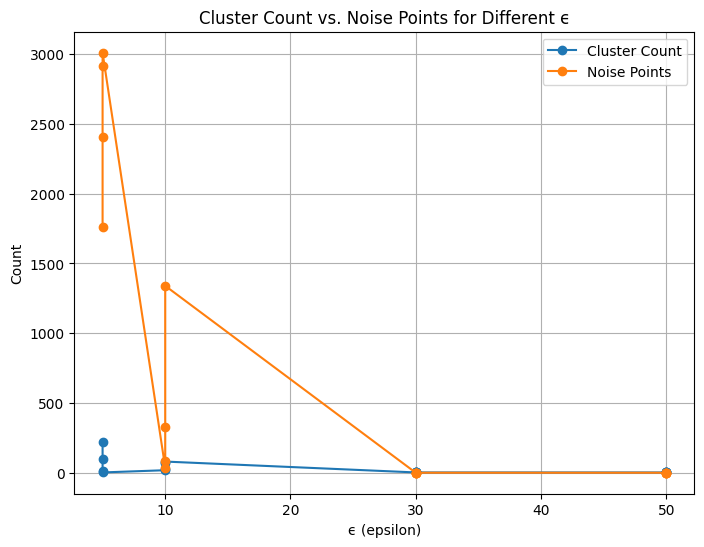

In [12]:
plt.figure(figsize=(8, 6))
plt.plot(performance_df["ϵ (epsilon)"], performance_df["Cluster Count"], label="Cluster Count", marker='o')
plt.plot(performance_df["ϵ (epsilon)"], performance_df["Noise Points"], label="Noise Points", marker='o')
plt.title("Cluster Count vs. Noise Points for Different ϵ")
plt.xlabel("ϵ (epsilon)")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.show()

可视化不同` epsilon `值下，聚类数量和噪声点数量的关系。

## 8. 计算并输出聚类评估指标

In [13]:
metrics = []
for epsilon in epsilons:
    for min_pts in min_pts_values:
        dbscan = DBSCAN(epsilon=epsilon, min_points=min_pts)
        dbscan.fit(X)
        
        if len(np.unique(dbscan.labels_)) > 1 and -1 not in np.unique(dbscan.labels_):
            silhouette = silhouette_score(X, dbscan.labels_)
        else:
            silhouette = -1  # 处理无法计算轮廓系数的情况
        
        try:
            nmi = normalized_mutual_info_score(true_labels, dbscan.labels_)
        except ValueError:
            nmi = -1
        
        try:
            ari = adjusted_rand_score(true_labels, dbscan.labels_)
        except ValueError:
            ari = -1
        
        metrics.append((epsilon, min_pts, silhouette, nmi, ari))

metrics_df = pd.DataFrame(metrics, columns=["ϵ (epsilon)", "min_pts", "Silhouette Score", "NMI", "ARI"])
print(metrics_df)

    ϵ (epsilon)  min_pts  Silhouette Score       NMI       ARI
0             5        4         -1.000000  0.322774 -0.012980
1             5        5         -1.000000  0.225914 -0.010082
2             5        7         -1.000000  0.052127 -0.008633
3             5       10         -1.000000  0.008906 -0.002740
4            10        4         -1.000000  0.846419  0.645471
5            10        5         -1.000000  0.772279  0.513550
6            10        7         -1.000000  0.594878  0.167329
7            10       10         -1.000000  0.415530  0.001129
8            30        4          0.293689  0.435804  0.214543
9            30        5          0.293689  0.435804  0.214543
10           30        7          0.293689  0.435804  0.214543
11           30       10          0.293689  0.435804  0.214543
12           50        4          0.293689  0.435804  0.214543
13           50        5          0.293689  0.435804  0.214543
14           50        7          0.293689  0.435804  0

使用轮廓系数（Silhouette Score）、`NMI`和`ARI`来评估 DBSCAN 聚类结果的质量。

## 结果分析

### 1. **聚类数与噪声点数分析**
首先，不同 **ϵ** 和 **min_pts** 设置下，聚类数和噪声点数的变化情况：

| **ϵ (epsilon)** | **min_pts** | **Cluster Count** | **Noise Points** |
|-----------------|-------------|-------------------|------------------|
| 5               | 4           | 217               | 1764             |
| 5               | 5           | 98                | 2407             |
| 5               | 7           | 14                | 2919             |
| 5               | 10          | 2                 | 3011             |
| 10              | 4           | 18                | 36               |
| 10              | 5           | 28                | 82               |
| 10              | 7           | 71                | 330              |
| 10              | 10          | 80                | 1340             |
| 30              | 4           | 2                 | 0                |
| 30              | 5           | 2                 | 0                |
| 30              | 7           | 2                 | 0                |
| 30              | 10          | 2                 | 0                |
| 50              | 4           | 2                 | 0                |
| 50              | 5           | 2                 | 0                |
| 50              | 7           | 2                 | 0                |
| 50              | 10          | 2                 | 0                |

#### **聚类数与噪声点数的观察**
1. **较小的 ϵ 值（如 ϵ = 5）**：
   - 当 **ϵ = 5** 时，随着 **min_pts** 增加，聚类数目急剧减少，而噪声点的数量大幅增加。例如：
     - **min_pts = 4** 时，检测到的簇数为 **217**，但噪声点数高达 **1764**。
     - **min_pts = 10** 时，聚类数只有 **2**，噪声点几乎占据了整个数据集（**3011**）。
   - 这表明，当 **ϵ** 较小且 **min_pts** 较小时，DBSCAN 会产生较多的小簇，同时产生大量噪声点。随着 **min_pts** 增加，噪声点增多，且大部分点被标记为噪声。

2. **较大的 ϵ 值（如 ϵ = 10）**：
   - 当 **ϵ** 增加至 **10**，邻域范围扩大，导致聚类数目减少。比如：
     - **min_pts = 4** 时，聚类数目降至 **18**，噪声点显著减少（**36**）。
     - **min_pts = 10** 时，聚类数为 **80**，噪声点大幅增加到 **1340**。
   - **ϵ = 10** 的情况下，较大的邻域能更好地识别数据中的聚类结构，但噪声点的数量取决于 **min_pts** 的选择。

3. **更大的 ϵ 值（如 ϵ = 30 和 ϵ = 50）**：
   - 随着 **ϵ** 增加到 **30** 或 **50**，聚类数目进一步减少，聚类结果趋向于一个单一的簇（即所有点都被聚成一个大簇）。例如：
     - 无论 **min_pts** 取何值（4、5、7、10），聚类数都保持为 **2**，噪声点几乎为 **0**。
   - 这意味着 **ϵ** 太大时，DBSCAN 的聚类能力降低，所有数据点几乎都被合并为一个簇，导致无法有效区分数据的不同结构。

### 2. **聚类质量评估（Silhouette Score、NMI 和 ARI）**

| **ϵ (epsilon)** | **min_pts** | **Silhouette Score** | **NMI**     | **ARI**      |
|-----------------|-------------|----------------------|-------------|--------------|
| 5               | 4           | -1.000               | 0.322774    | -0.012980    |
| 5               | 5           | -1.000               | 0.225914    | -0.010082    |
| 5               | 7           | -1.000               | 0.052127    | -0.008633    |
| 5               | 10          | -1.000               | 0.008906    | -0.002740    |
| 10              | 4           | -1.000               | 0.846419    | 0.645471     |
| 10              | 5           | -1.000               | 0.772279    | 0.513550     |
| 10              | 7           | -1.000               | 0.594878    | 0.167329     |
| 10              | 10          | -1.000               | 0.415530    | 0.001129     |
| 30              | 4           | 0.293689             | 0.435804    | 0.214543     |
| 30              | 5           | 0.293689             | 0.435804    | 0.214543     |
| 30              | 7           | 0.293689             | 0.435804    | 0.214543     |
| 30              | 10          | 0.293689             | 0.435804    | 0.214543     |
| 50              | 4           | 0.293689             | 0.435804    | 0.214543     |
| 50              | 5           | 0.293689             | 0.435804    | 0.214543     |
| 50              | 7           | 0.293689             | 0.435804    | 0.214543     |
| 50              | 10          | 0.293689             | 0.435804    | 0.214543     |

#### **轮廓系数**：
- 在 **ϵ = 5** 的情况下，**Silhouette Score** 为 **-1**，表明聚类结果极差，是由于噪声点过多或簇间距离过小。随着 **min_pts** 增加，**Silhouette Score** 没有显著改善，依然为负值，表明聚类效果差。
- 对于 **ϵ = 10**，尽管 **Silhouette Score** 仍然为 **-1**，但相较于 **ϵ = 5** 时的情况略有改善。
- 对于 **ϵ = 30** 和 **ϵ = 50**，**Silhouette Score** 稍微提高，变为 **0.29**。这表明在较大的 **ϵ** 值下，DBSCAN 算法能找到更加合理的聚类结构。

#### **NMI**：
- 在 **ϵ = 5** 的情况下，**NMI** 显示较低的值（约 0.22 到 0.32），表明聚类结果与真实标签的匹配程度较低。
- 对于 **ϵ = 10**，**NMI** 显著提高，尤其是在 **min_pts = 4** 和 **min_pts = 5** 时，接近 **0.85**，显示出较强的聚类结构。
- 对于 **ϵ = 30** 和 **ϵ = 50**，**NMI** 稳定在 **0.44** 左右，虽然较小 **ϵ** 时略有下降，但仍然表现不错。

#### **ARI**：
- 在 **ϵ = 5** 时，**ARI** 较低，且为负值，表明聚类结果与真实标签几乎无关。
- 对于 **ϵ = 10**，**ARI** 值有所改善，尤其是在 **min_pts = 4** 时，值为 **0.645**，表示聚类结果与真实标签有较强的关联性。
- 在 **ϵ = 30** 和 **ϵ = 50** 时，**ARI** 维持在较低水平（约 **0.21**），表明虽然聚类效果有所改善，但聚类结构可能过于简化。

### 3. **结果总结**

#### **最佳聚类参数**：
- **ϵ = 10**，**min_pts = 4** 或

 **min_pts = 5** 显示了较好的聚类结果，特别是在 **NMI** 和 **ARI** 上表现较好。此时，聚类效果相对较优，噪声点数量适中，且能够与真实标签较好匹配。
  
#### **较差的聚类参数**：
- **ϵ = 5**，无论 **min_pts** 设置为何值，都导致聚类效果较差。噪声点过多，且聚类结果无法有效识别数据结构，**Silhouette Score** 和 **ARI** 均表现为负值。
  
#### **大 **ϵ** 值的影响**：
- 当 **ϵ** 进一步增大到 **30** 和 **50** 时，聚类数减少，噪声点消失，但聚类质量并未显著提高，反而聚类结果趋向于一个统一的大簇，导致聚类的精度和有效性降低。

### 4. **结论**：
**ϵ = 10** 和 **min_pts = 4/5** 是最优选择，能够有效平衡噪声点和聚类数量，并提供较好的聚类质量。

## 完整代码

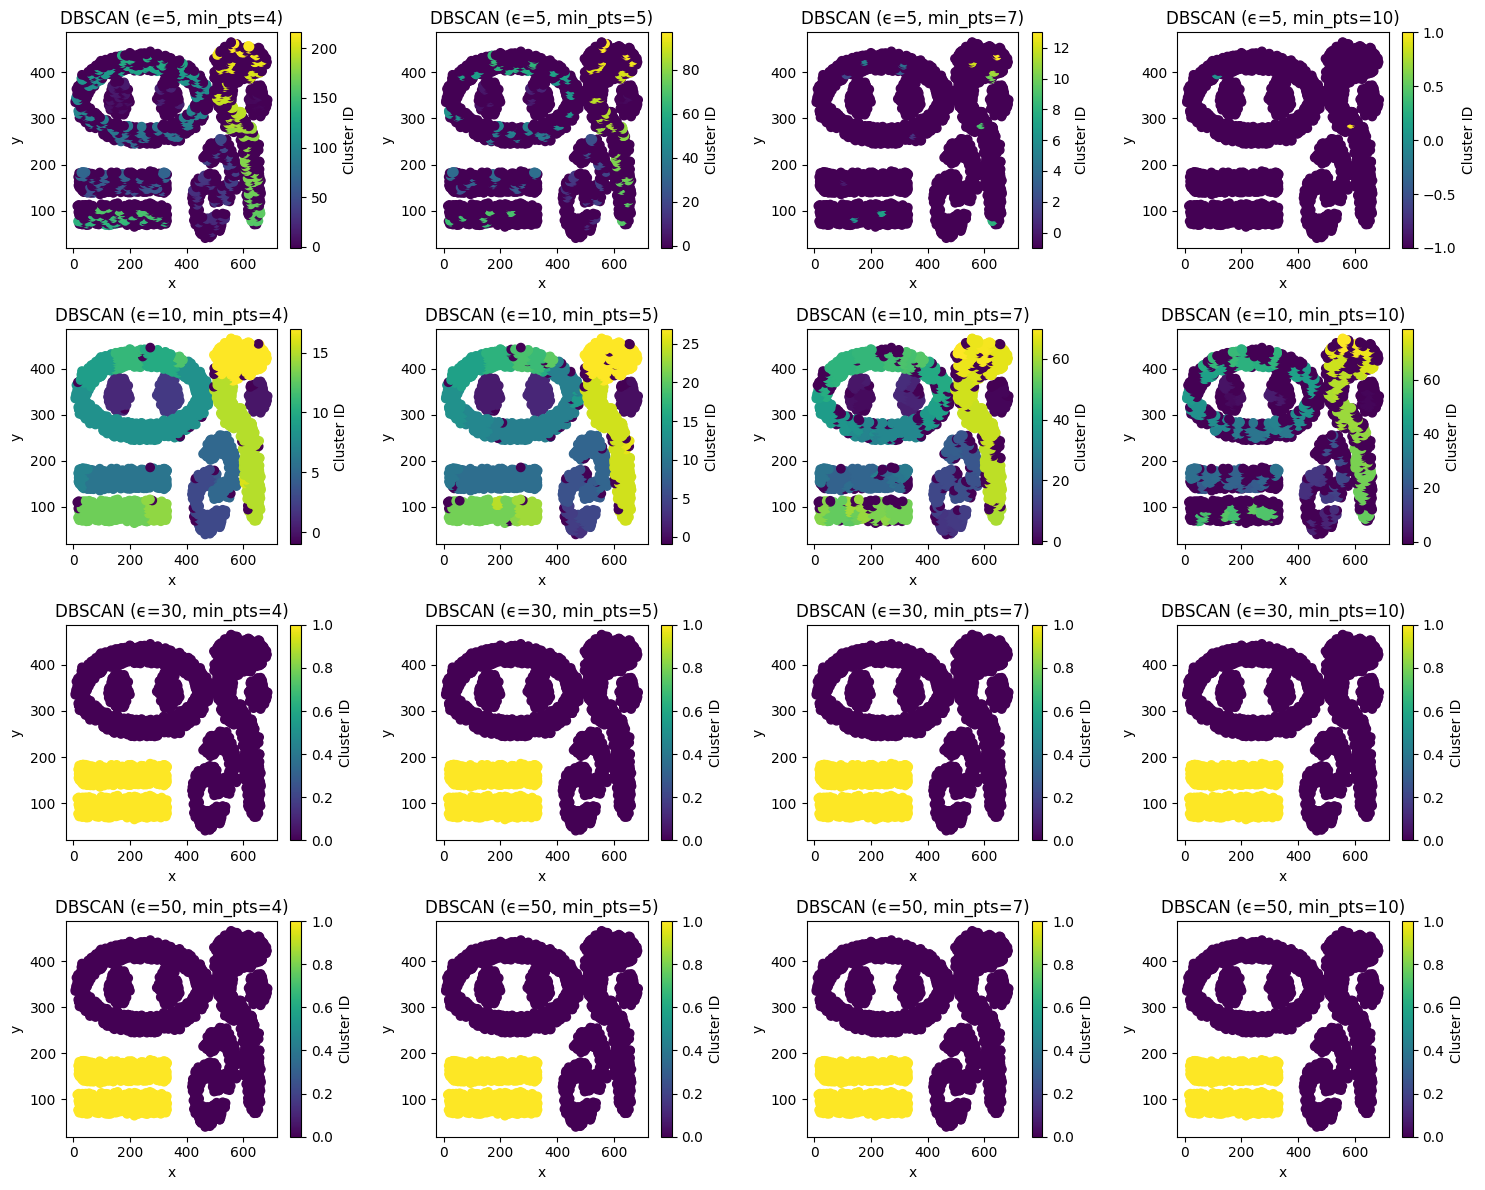

    ϵ (epsilon)  min_pts  Cluster Count  Noise Points
0             5        4            217          1764
1             5        5             98          2407
2             5        7             14          2919
3             5       10              2          3011
4            10        4             18            36
5            10        5             28            82
6            10        7             71           330
7            10       10             80          1340
8            30        4              2             0
9            30        5              2             0
10           30        7              2             0
11           30       10              2             0
12           50        4              2             0
13           50        5              2             0
14           50        7              2             0
15           50       10              2             0


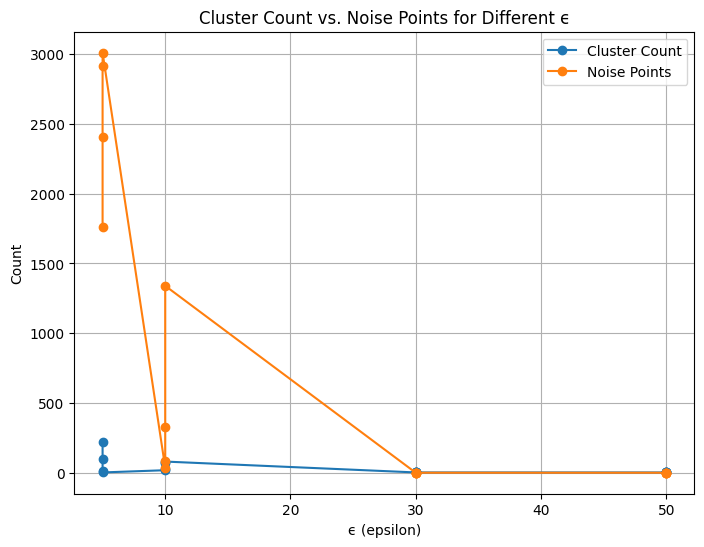

    ϵ (epsilon)  min_pts  Silhouette Score       NMI       ARI
0             5        4         -1.000000  0.322774 -0.012980
1             5        5         -1.000000  0.225914 -0.010082
2             5        7         -1.000000  0.052127 -0.008633
3             5       10         -1.000000  0.008906 -0.002740
4            10        4         -1.000000  0.846419  0.645471
5            10        5         -1.000000  0.772279  0.513550
6            10        7         -1.000000  0.594878  0.167329
7            10       10         -1.000000  0.415530  0.001129
8            30        4          0.293689  0.435804  0.214543
9            30        5          0.293689  0.435804  0.214543
10           30        7          0.293689  0.435804  0.214543
11           30       10          0.293689  0.435804  0.214543
12           50        4          0.293689  0.435804  0.214543
13           50        5          0.293689  0.435804  0.214543
14           50        7          0.293689  0.435804  0

In [15]:
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, normalized_mutual_info_score, adjusted_rand_score

# Step 1: 计算欧几里得距离
def euclidean_distance(point1, point2):
    return sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

# Step 2: DBSCAN实现
class DBSCAN:
    def __init__(self, epsilon=0.5, min_points=5):
        self.epsilon = epsilon
        self.min_points = min_points
        self.labels_ = None
        
    def fit(self, X):
        n_samples = len(X)
        self.labels_ = np.full(n_samples, -1)  # -1表示噪声点
        cluster_id = 0
        visited = np.zeros(n_samples, dtype=bool)
        
        # 查找某个点的邻域
        def region_query(i):
            neighbors = []
            for j in range(n_samples):
                if euclidean_distance(X[i], X[j]) < self.epsilon:
                    neighbors.append(j)
            return neighbors
        
        # 扩展簇
        def expand_cluster(i, neighbors, cluster_id):
            self.labels_[i] = cluster_id
            queue = neighbors[:]
            while queue:
                j = queue.pop(0)
                if not visited[j]:
                    visited[j] = True
                    new_neighbors = region_query(j)
                    if len(new_neighbors) >= self.min_points:
                        queue.extend(new_neighbors)
                if self.labels_[j] == -1:
                    self.labels_[j] = cluster_id
        
        # DBSCAN主过程
        for i in range(n_samples):
            if not visited[i]:
                visited[i] = True
                neighbors = region_query(i)
                if len(neighbors) < self.min_points:
                    self.labels_[i] = -1  # 噪声点
                else:
                    expand_cluster(i, neighbors, cluster_id)
                    cluster_id += 1

# Step 3: 加载数据
file_path = '/home/aistudio/dataset/02-Synthetic/complex9.csv'
data = pd.read_csv(file_path)

# 数据格式预处理
X = data[['x', 'y']].values
true_labels = data['class'].values  # 假设 `class` 是真实标签

# Step 4: 测试DBSCAN并可视化不同的epsilon值
epsilons = [5, 10, 30, 50]  # 尝试不同的 epsilon 值
min_pts_values = [4, 5, 7, 10]  # 尝试不同的 min_pts 值
performance_metrics = []

# 使用plt.subplots创建自适应布局
fig, axes = plt.subplots(len(epsilons), len(min_pts_values), figsize=(15, 12))

plt.subplots_adjust(hspace=0.4, wspace=0.4)  # 调整子图间的距离

for i, epsilon in enumerate(epsilons):
    for j, min_pts in enumerate(min_pts_values):
        dbscan = DBSCAN(epsilon=epsilon, min_points=min_pts)
        dbscan.fit(X)
        data['cluster'] = dbscan.labels_

        # 统计聚类结果
        unique_labels = np.unique(dbscan.labels_)
        num_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)  # 排除噪声
        num_noise = np.sum(dbscan.labels_ == -1)
        performance_metrics.append((epsilon, min_pts, num_clusters, num_noise))
        
        # 可视化聚类结果
        ax = axes[i, j]
        scatter = ax.scatter(data['x'], data['y'], c=data['cluster'], cmap='viridis', marker='o')
        ax.set_title(f"DBSCAN (ϵ={epsilon}, min_pts={min_pts})")
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        fig.colorbar(scatter, ax=ax, label='Cluster ID')

plt.tight_layout()
plt.show()

# Step 5: 打印不同参数对模型性能的影响
performance_df = pd.DataFrame(performance_metrics, columns=["ϵ (epsilon)", "min_pts", "Cluster Count", "Noise Points"])
print(performance_df)

# Step 6: 进一步分析ϵ-邻域大小对聚类结果的影响
# 聚类数与噪声点的关系
plt.figure(figsize=(8, 6))
plt.plot(performance_df["ϵ (epsilon)"], performance_df["Cluster Count"], label="Cluster Count", marker='o')
plt.plot(performance_df["ϵ (epsilon)"], performance_df["Noise Points"], label="Noise Points", marker='o')
plt.title("Cluster Count vs. Noise Points for Different ϵ")
plt.xlabel("ϵ (epsilon)")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.show()

# Step 7: 计算并输出轮廓系数 (Silhouette Score), NMI 和 ARI
metrics = []
for epsilon in epsilons:
    for min_pts in min_pts_values:
        dbscan = DBSCAN(epsilon=epsilon, min_points=min_pts)
        dbscan.fit(X)
        
        # 计算轮廓系数（Silhouette Score）
        if len(np.unique(dbscan.labels_)) > 1 and -1 not in np.unique(dbscan.labels_):
            silhouette = silhouette_score(X, dbscan.labels_)
        else:
            silhouette = -1  # 如果聚类结果为噪声点或只有一个簇，则无法计算
        
        # 计算 NMI（Normalized Mutual Information）
        try:
            nmi = normalized_mutual_info_score(true_labels, dbscan.labels_)
        except ValueError:
            nmi = -1  # 当聚类没有有效标签时处理
        
        # 计算 ARI（Adjusted Rand Index）
        try:
            ari = adjusted_rand_score(true_labels, dbscan.labels_)
        except ValueError:
            ari = -1  # 如果聚类没有有效标签则跳过
        
        metrics.append((epsilon, min_pts, silhouette, nmi, ari))

# 输出结果
metrics_df = pd.DataFrame(metrics, columns=["ϵ (epsilon)", "min_pts", "Silhouette Score", "NMI", "ARI"])
print(metrics_df)
